# Set up

#### Import useful packages and functions

In [1]:
import copy
from datetime import datetime
import os
import sys

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from poluk import *

#### Read in the raw data
This is a file straight from Electoral Calculus, but it can be changed to a local file so long as it's in the same format. If you're not interested in Northern Ireland seats, change True to False. Here I'm renaming UKIP to Brexit, but your needs may be different.

In [4]:
raw = pd.read_csv(r'https://www.electoralcalculus.co.uk/electdata_2015.txt',sep=';')
raw.rename(columns={'UKIP':'Brexit'}, inplace=True)
data = process(raw.copy(), keep_ni=True)

This file gives the geographic centre-point of each constituency, adapted from ONS data, necessary for creating maps. It only covers the constituencies that exist IRL now (ie since the 2007 boundary review). If the scenario is before then, the maps will break.

In [5]:
centroids=pd.read_csv(r'C:\Users\Andy\Documents\PolUK\Election Data\constituency_centroids_2010.csv')
centroids.columns = ['Name', 'long', 'lat']

#### Label player's seats
You can add to this dictionary in the same format, ie Seat Name: Character Name. Seat names must be what they're called in the raw file. Electoral Calculus has a habit of putting compass points at the end of seat names, even if that differs from the official name. If you put in a seat name that doesn't exist, the error should tell you which one.

In [6]:
player_seats = {
    'Bognor Regis and Littlehampton':'Robert Lascelles',
    'Liverpool Riverside':'James Arnold',
    'Nottingham South':'Sarah Nyland',
    'Rhondda':'Mitch Un',
    'Dorset North':'William Croft',
    'Dumfriesshire, Clydesdale and Tweeddale':'Calum Wilson',
    'Holborn and St Pancras':'David Levy',
    'Manchester Central':'Caroline Blakesley',
    'Leeds North West':'Grant Smith',
}
assert len(player_seats)==data[data.Name.isin(player_seats.keys())].shape[0], 'A seat name in the player list is not correct: '+','.join([x for x in player_seats.keys() if x not in data.Name.values])
data['MP'] = data['Name'].map(player_seats).fillna(data['MP'])

# Current state of play

In [7]:
data['Winner'].value_counts()

CON       331
LAB       232
SNP        56
LIB         8
DUP         8
SF          4
Plaid       3
SDLP        3
UUP         2
Green       1
MIN         1
Brexit      1
Name: Winner, dtype: int64

In [8]:
largest_party = data['Winner'].value_counts().head(1)
if largest_party[0]>650/2:
    print('{} majority: {}'.format(largest_party.index[0],largest_party[0]*2 - 650))
else:
    print('{} largest party, short by {}'.format(largest_party.index[0],int((650/2)-largest_party[0])))

CON majority: 12


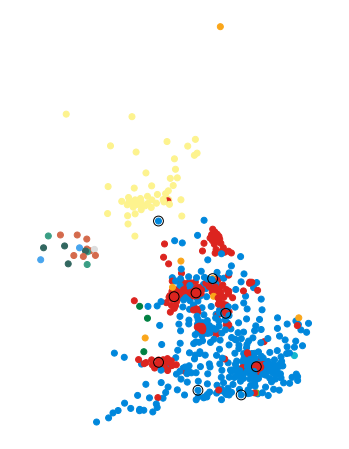

In [9]:
constituency_map(data, centroids, by=['Winner'], highlight=list(player_seats.keys()))

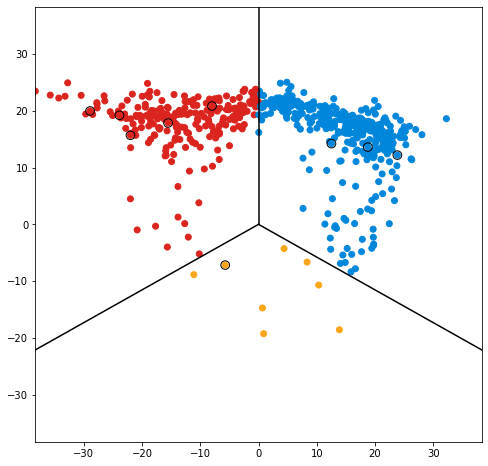

In [10]:
battleground(data, ['LAB', 'CON', 'LIB'], highlight=player_seats.keys())

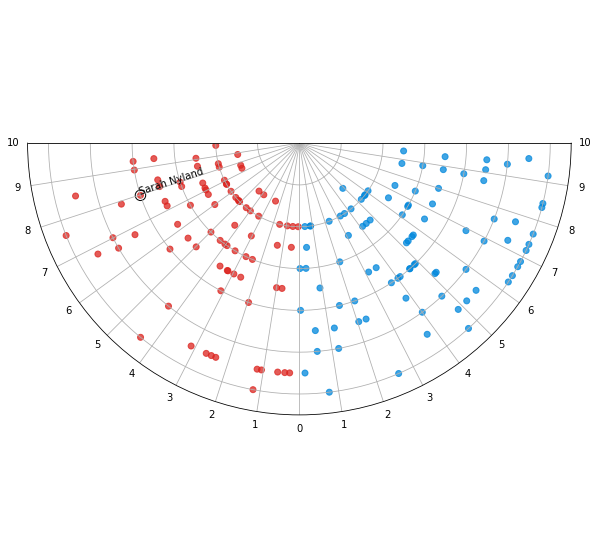

In [11]:
swingometer(data, ['LAB', 'CON'], highlight=list(player_seats.keys()), highlight_label='MP')

#### Players in danger

In [12]:
data.loc[(data.Name.isin(player_seats.keys()))&(data.Swing_to_gain_pct<5),
        ['Name','MP','Area','County','Winner','Swing_to_gain_pct']
        ].sort_values('Swing_to_gain_pct')

,Name,MP,Area,County,Winner,Swing_to_gain_pct
588,"Dumfriesshire, Clydesdale and Tweeddale",Calum Wilson,2,Dumfries and Galloway,CON,0.765335
275,Leeds North West,Grant Smith,5,West Yorkshire,LIB,3.352400


#### Defences

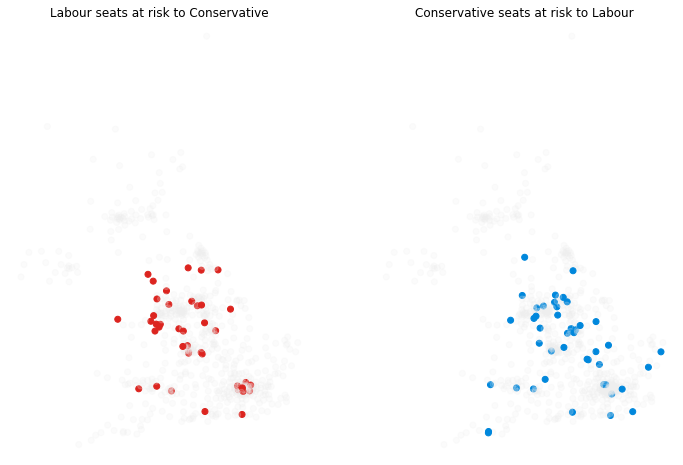

In [13]:
data['LAB_risk_to_CON'] = np.where((data.Winner=='LAB')&(data.CON_swing_needed<=5),'LAB','blank')
data['CON_risk_to_LAB'] = np.where((data.Winner=='CON')&(data.LAB_swing_needed<=5),'CON','blank')
constituency_map(data, centroids, by=['LAB_risk_to_CON', 'CON_risk_to_LAB'], #alpha=0.4, 
                 title=['Labour seats at risk to Conservative', 'Conservative seats at risk to Labour'])

#### Targets

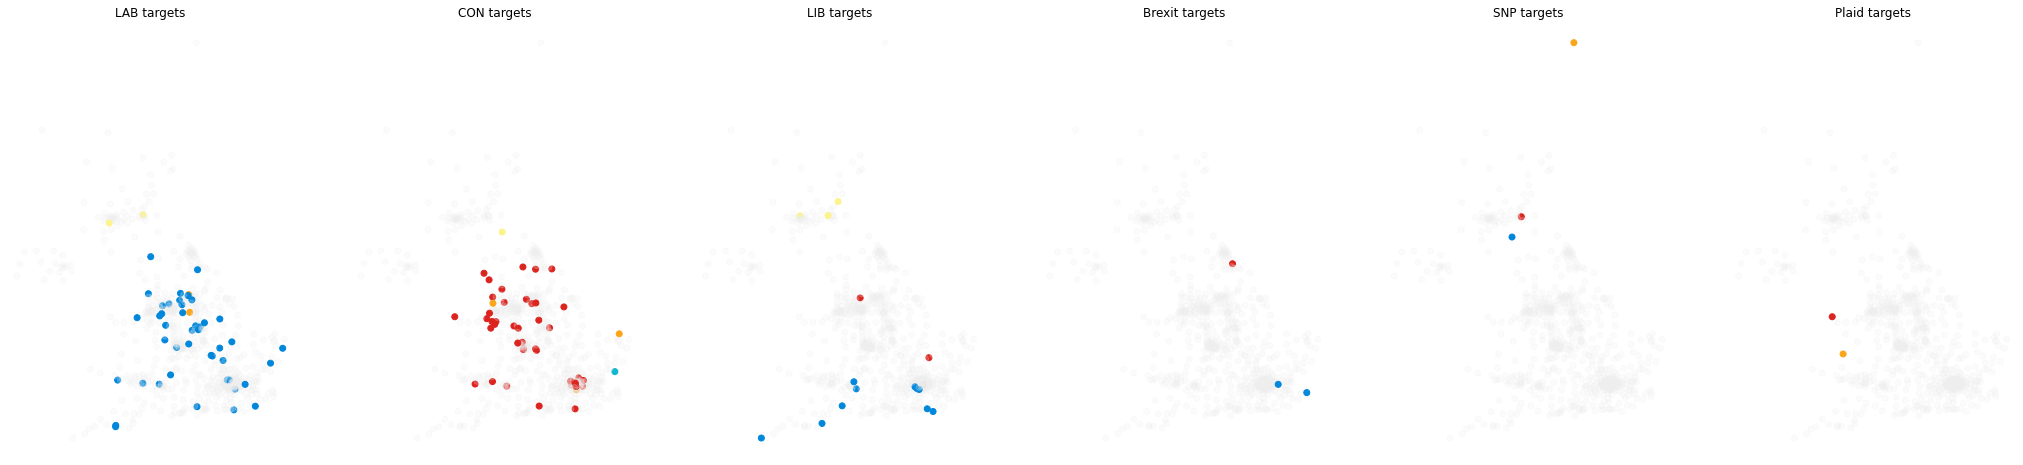

In [14]:
parties = ['LAB', 'CON', 'LIB', 'Brexit', 'SNP', 'Plaid']
for p in parties:
    data[p+'_target'] = np.where((data.Winner!=p)&(data[p+'_swing_needed']<=5),data['Winner'],'blank')
constituency_map(data, centroids, by=[p+'_target' for p in parties], title=[p+' targets' for p in parties])

# Polling

#### Fill in the polls here
The extra_CON_LAB variable allows you to easily test out different scenarios.

In [15]:
extra_CON_LAB = 0

# Latest poll 
polling = {'LAB':    np.mean([40,41,41,40,41])-extra_CON_LAB,
           'CON':    np.mean([38,39,38,38,39])+extra_CON_LAB,
           'Brexit': np.mean([10, 9,10, 9,10]),
           'LIB':    np.mean([ 8, 7, 7, 8, 6]),
           'Green':  np.mean([0.2,0.2,0.2,0.2,0.3]),
          }
scottish_polling = {'SNP':  np.mean([30]),
                    'CON':  np.mean([33])+extra_CON_LAB,
                    'LAB':  np.mean([28])-extra_CON_LAB,
                    'LIB':  np.mean([ 6]),
                   }
welsh_polling = {'LAB':   np.mean([35])-extra_CON_LAB,
                 'CON':   np.mean([32])+extra_CON_LAB,
                 'Plaid': np.mean([25]),
                 'LIB':   np.mean([ 8]),
                }

ni_polling = {'DUP': 31,
              'SF':  27,
              'UUP': 14,
              'SDLP':10,
              'APNI': 8}

polls_list = [[[2],[2],scottish_polling],
              [[6],[6],welsh_polling],
              [[1],[1],ni_polling],
              [[2,3,4,5,6,7,8,9,10,11,12],[3,4,5,7,8,9,10,11,12],polling]]

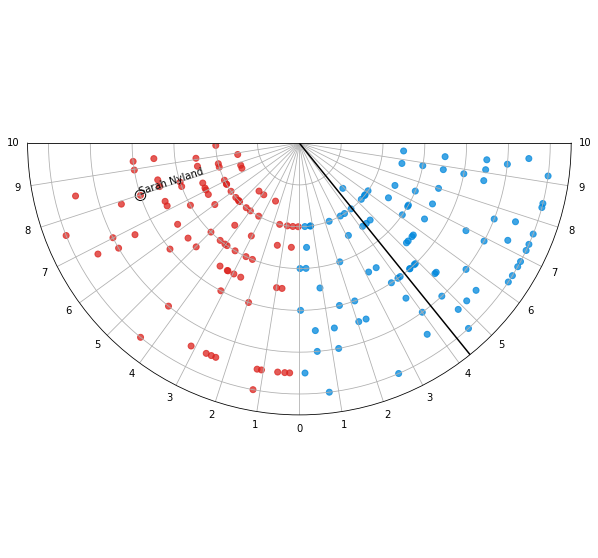

In [16]:
swingometer(data, ['LAB', 'CON'], shift=polling, highlight=list(player_seats.keys()), highlight_label='MP')

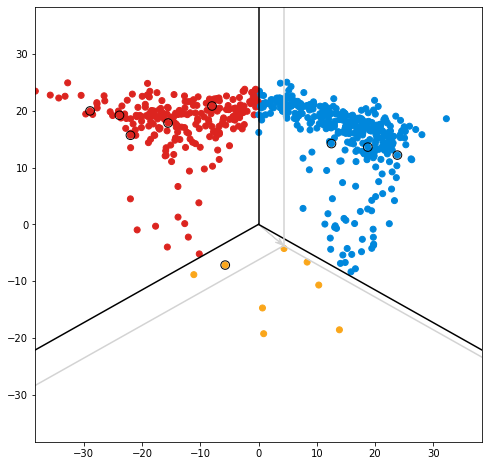

In [17]:
battleground(data, ['LAB', 'CON', 'LIB'], shift=polling, highlight=list(player_seats.keys()))

# Forecast

In [18]:
forecast_data = forecast(data.copy(), polls_list)

In [19]:
pd.DataFrame(forecast_data['Winner_forecast'].value_counts()).rename(columns={'Winner_forecast':'Seats'})

,Seats
CON,319
LAB,276
SNP,20
LIB,10
DUP,10
Plaid,5
SF,5
SDLP,2
Green,1
MIN,1


In [20]:
largest_party = forecast_data['Winner_forecast'].value_counts().head(1)
if largest_party[0]>650/2:
    print('{} majority: {}'.format(largest_party.index[0],largest_party[0]*2 - 650))
else:
    print('{} largest party, short by {}'.format(largest_party.index[0],int((650/2)-largest_party[0])))

CON largest party, short by 6


In [21]:
forecast_data['Winner_forecast'].value_counts()-data['Winner'].value_counts()

Brexit     0.0
CON      -12.0
DUP        2.0
Green      0.0
LAB       44.0
LIB        2.0
MIN        0.0
Plaid      2.0
SDLP      -1.0
SF         1.0
SNP      -36.0
UUP        NaN
dtype: float64

#### Seat change flows

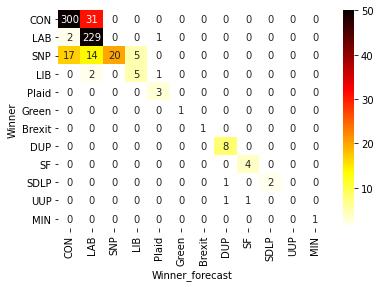

In [22]:
parties_gb_prev = list(forecast_data.loc[forecast_data.Area!=1,'Winner'].value_counts().index)
parties_gb_next = list(forecast_data.loc[forecast_data.Area!=1,'Winner_forecast'].value_counts().index)
parties_ni_prev = list(forecast_data.loc[forecast_data.Area==1,'Winner'].value_counts().index)
parties_ni_next = list(forecast_data.loc[forecast_data.Area==1,'Winner_forecast'].value_counts().index)
parties_in_order = parties_gb_prev + [x for x in parties_gb_next if x not in parties_gb_prev] + parties_ni_prev + [x for x in parties_ni_next if x not in parties_ni_prev]
graphdata = pd.crosstab(forecast_data['Winner'],forecast_data['Winner_forecast'],margins=True, margins_name='Total'
                       ).reindex(parties_in_order).reindex(parties_in_order, axis=1).fillna(0).astype(int)
plt.figure()
sns.heatmap(graphdata, annot=True, fmt="d", cmap='hot_r', vmin=1, vmax=50)
plt.show()

#### Minor party seat wins
"Minor" being anyone except the main 3, the nationalists and the NI main 4

In [23]:
forecast_data.loc[~forecast_data['Winner_forecast'].isin(['CON','LAB','LIB','SNP','Plaid','DUP','UUP','SDLP','SF']),
             ['Name','MP','Region','County','Winner','Winner_forecast']]

,Name,MP,Region,County,Winner,Winner_forecast
72,Brighton Pavilion,Caroline Lucas,South East,East Sussex,Green,Green
117,Clacton,Douglas Carswell,Anglia,Essex,Brexit,Brexit
639,Down North,Lady Sylvia Hermon,Northern Ireland,Down,MIN,MIN


#### Players losing their seat

In [24]:
forecast_data.loc[(forecast_data.Winner!=forecast_data.Winner_forecast)&(forecast_data['Name'].isin(player_seats.keys())),['Name','MP','Region','County','Winner','Winner_forecast','Swing_to_gain_after_forecast_pct']].sort_values('Name')

,Name,MP,Region,County,Winner,Winner_forecast,Swing_to_gain_after_forecast_pct
275,Leeds North West,Grant Smith,Yorks / Humber,West Yorkshire,LIB,LAB,1.787394


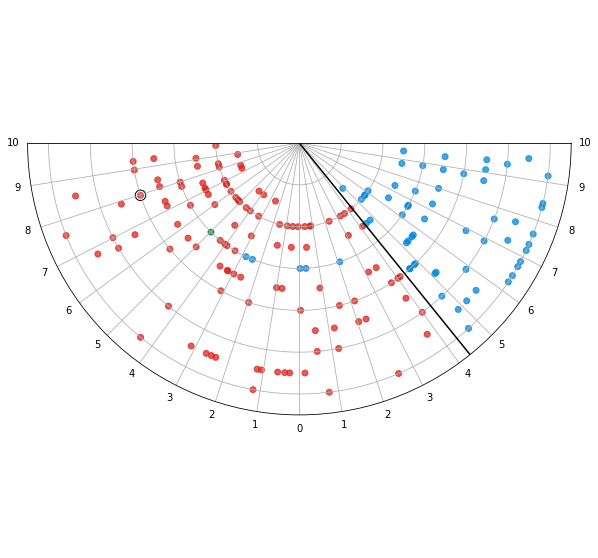

In [25]:
swingometer(forecast_data, ['LAB', 'CON'], colour_by='Winner_forecast',
            shift=polling, 
            highlight=list(player_seats.keys()))

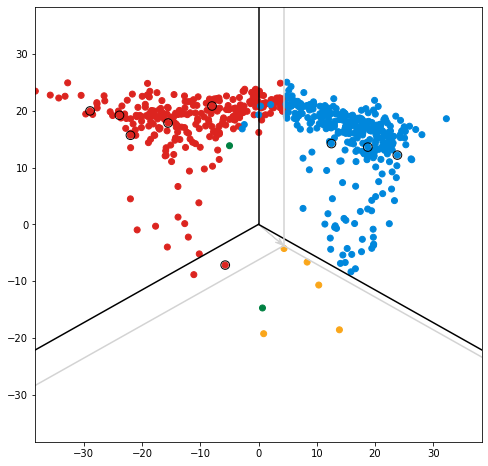

In [26]:
battleground(forecast_data, ['LAB', 'CON', 'LIB'], colour_by='Winner_forecast',
            shift=polling, highlight=list(player_seats.keys()))

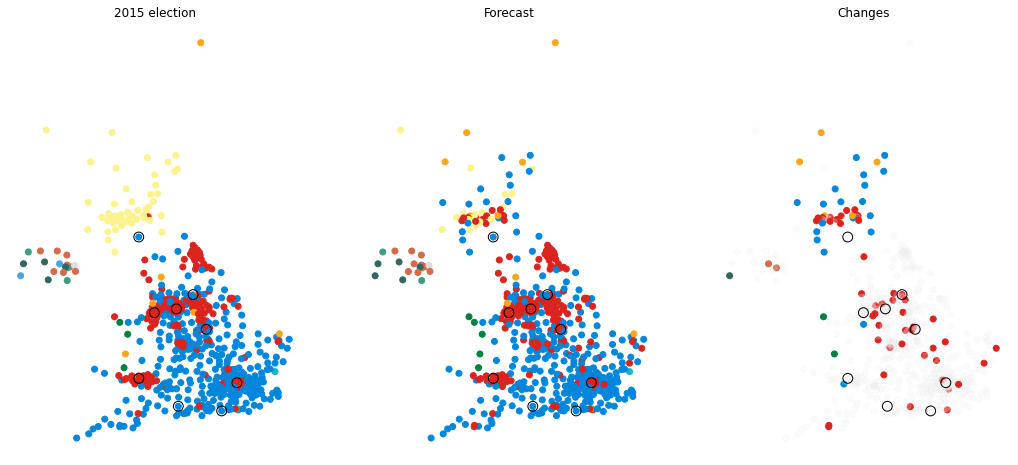

In [27]:
forecast_data['Seat_Change'] = np.where(forecast_data['Winner']!=forecast_data['Winner_forecast'],
                                        forecast_data['Winner_forecast'],'blank')
constituency_map(forecast_data, centroids, by=['Winner', 'Winner_forecast', 'Seat_Change'], highlight=list(player_seats.keys()),
                 title=['2015 election','Forecast', 'Changes'])

# Simulation
This will simulate 1000 elections, to find the probability of various events. It takes around 6 mins for me, YMMV.

In [28]:
results = []
N=1000
print(datetime.now())
for i in range(N):
    if i % int(N/10) == 0:
        print(i)
    temp_list = copy.deepcopy(polls_list)
    for s in temp_list:
        d=s[2]
        s[2]={k: v+(np.random.uniform(-1,1)*3.29*np.sqrt((v/100)*(1-(v/100))/1000))*100 for k,v in d.items()}
    sim = forecast(data.copy(), temp_list)
    results.append(sim['Winner_forecast'].value_counts())
print(datetime.now())
sim_results = pd.concat(results, axis=1, sort=True).fillna(0).T.reset_index(drop=True)

2020-05-03 11:59:47.505669
0
100
200
300
400
500
600
700
800
900
2020-05-03 12:03:43.683098


In [29]:
summary = sim_results.describe([0.1,0.9]).astype(int).loc[['50%','10%','90%']].T
summary.columns = ['Central', 'Low', 'High']
summary['Central'] = forecast_data['Winner_forecast'].value_counts()
display(summary.sort_values('Central', ascending=False))

,Central,Low,High
CON,319.0,291,343
LAB,276.0,252,310
SNP,20.0,6,29
DUP,10.0,10,10
LIB,10.0,7,13
Plaid,5.0,4,6
SF,5.0,4,5
SDLP,2.0,2,2
Brexit,1.0,0,1
Green,1.0,0,1


In [30]:
sim_results['outcome'] = np.where(sim_results.CON>322.5,'CON majority',
                                  np.where(sim_results.LAB>322.5,'LAB majority',
                                           np.where(sim_results.CON+sim_results.Brexit>322.5,'CON+Brexit coalition',
                                                    np.where((sim_results.LAB+sim_results.LIB>322.5)&(sim_results.LAB+sim_results.SNP+sim_results.Plaid>322.5),'LAB choice of LIB or NAT',
                                                             np.where(sim_results.LAB+sim_results.LIB>322.5,'LAB+LIB coalition',
                                                                      np.where(sim_results.LAB+sim_results.SNP+sim_results.Plaid>322.5,'LAB+NAT coalition',
                                                                               np.where(sim_results.LAB+sim_results.LIB+sim_results.SNP+sim_results.Plaid>322.5,'LAB+LIB+NAT coalition',
                                                                                        np.where(sim_results.LAB+sim_results.LIB+sim_results.SNP+sim_results.Plaid+sim_results.Green>322.5,'LAB+LIB+NAT+Green coalition',
    'No coalition'))))))))
prob = pd.DataFrame((sim_results['outcome'].value_counts()/N).round(3))
prob.rename(columns={'outcome':'Probability'}, inplace=True)
prob.style.format({'Probability': '{:.1%}'})

,Probability
CON majority,47.6%
No coalition,18.6%
LAB+LIB+NAT coalition,13.3%
LAB+NAT coalition,9.4%
LAB choice of LIB or NAT,5.8%
LAB majority,2.5%
CON+Brexit coalition,1.7%
LAB+LIB+NAT+Green coalition,0.7%
LAB+LIB coalition,0.4%


# Appendix
Many lovely graphs and images you may or may not care about

#### Swingometers of each party against each other

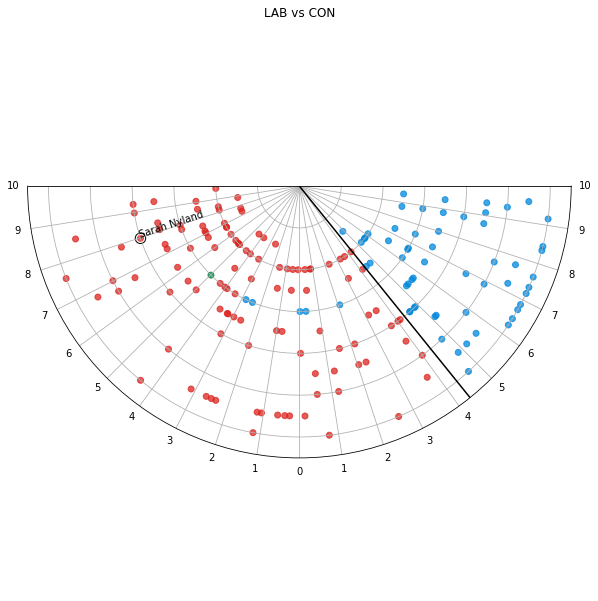

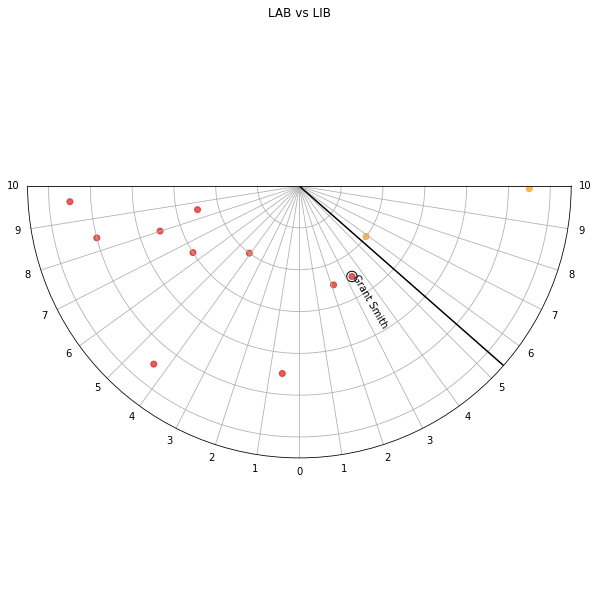

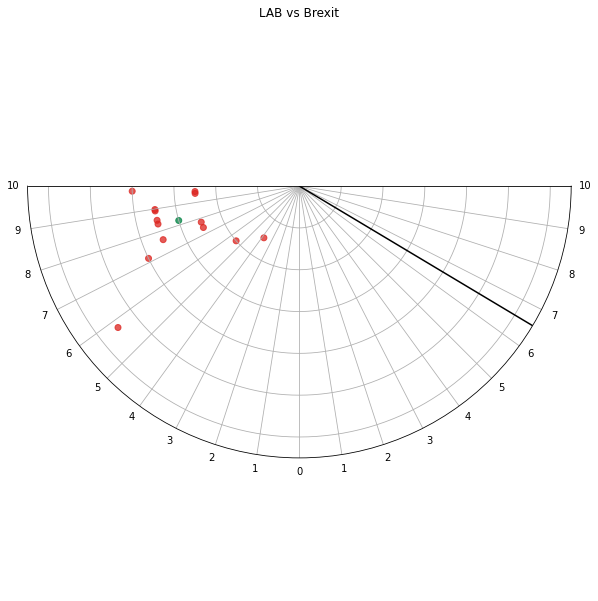

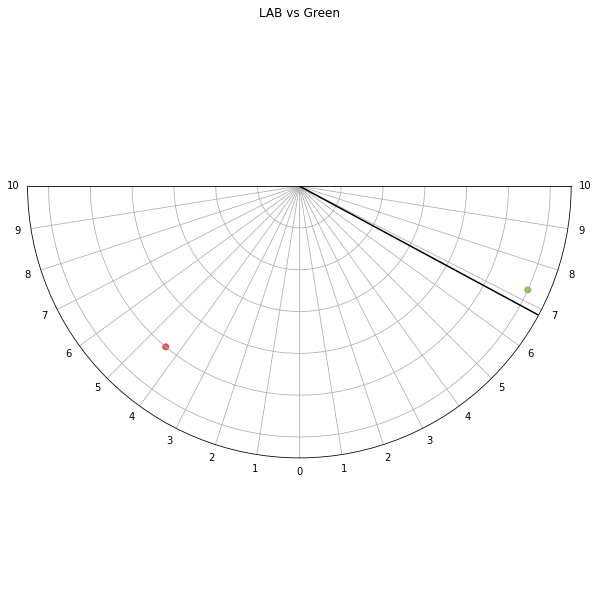

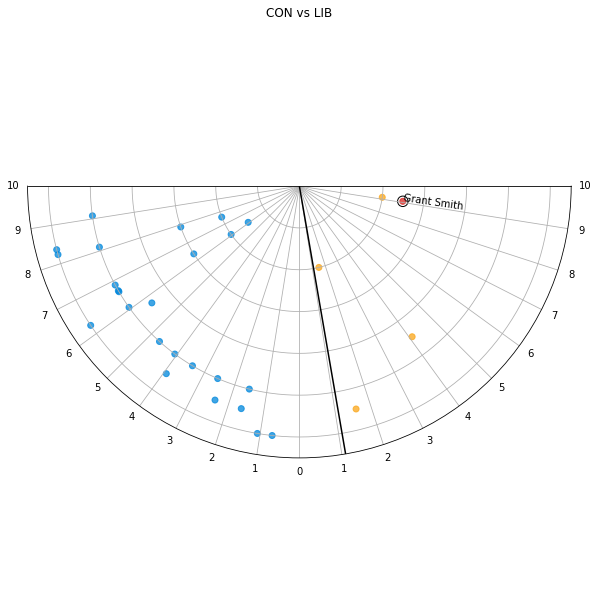

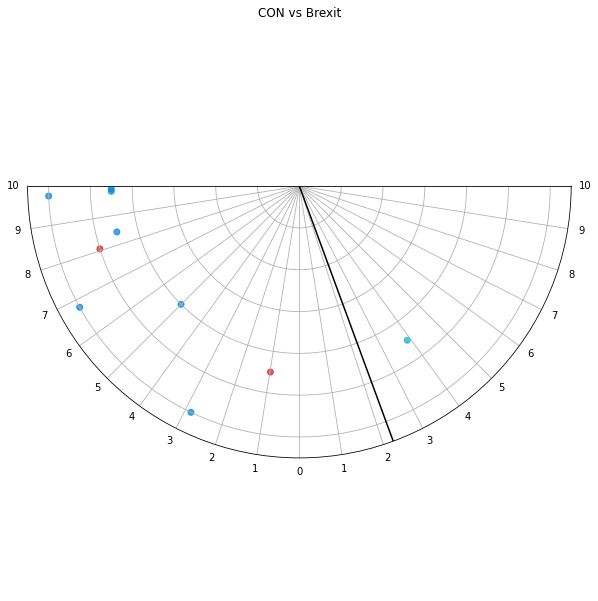

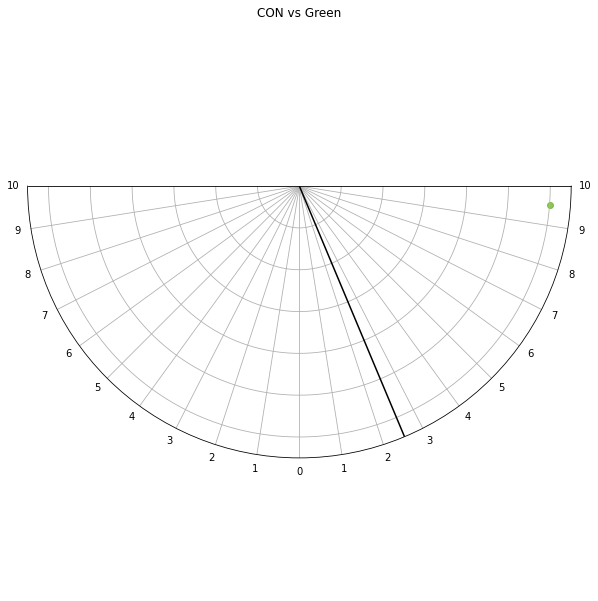

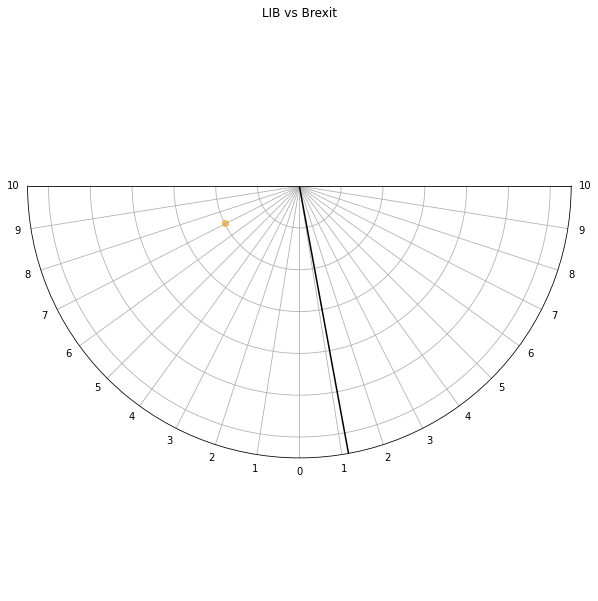

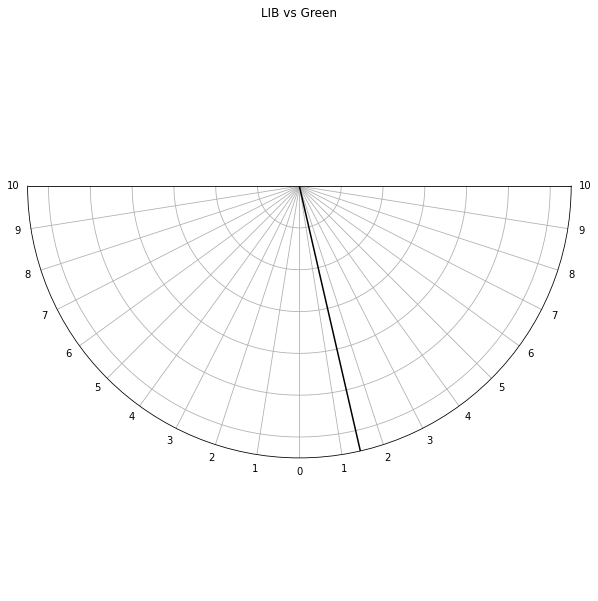

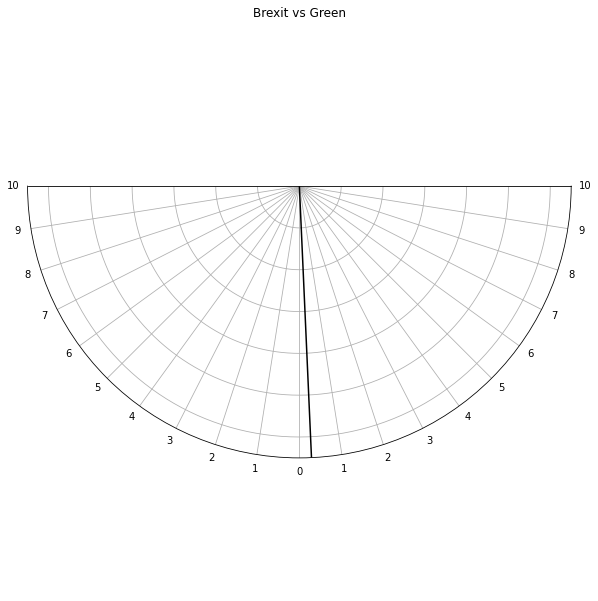

In [31]:
swingometer_parties = ['LAB', 'CON', 'LIB', 'Brexit', 'Green']
for i in range(len(swingometer_parties)-1):
    p1 = swingometer_parties[i]
    for p2 in swingometer_parties[i+1:]:
        swingometer(forecast_data, [p1, p2], colour_by='Winner_forecast', shift=polling,
                    highlight=list(player_seats.keys()), highlight_label='MP', title=p1+' vs '+p2)

#### Battlegrounds of LAB v CON v another

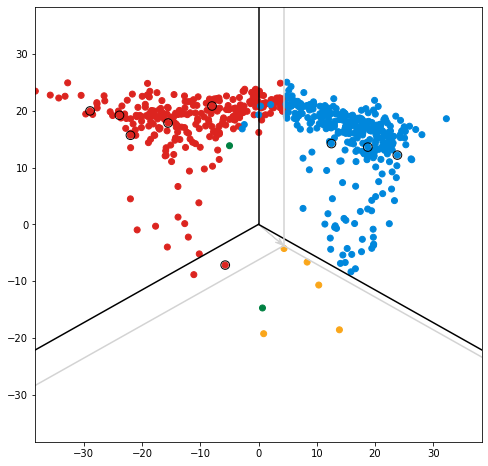

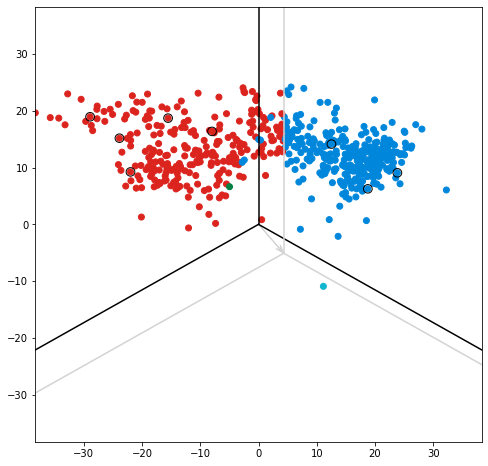

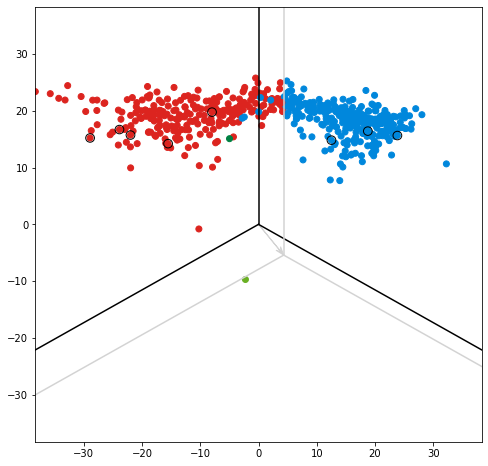

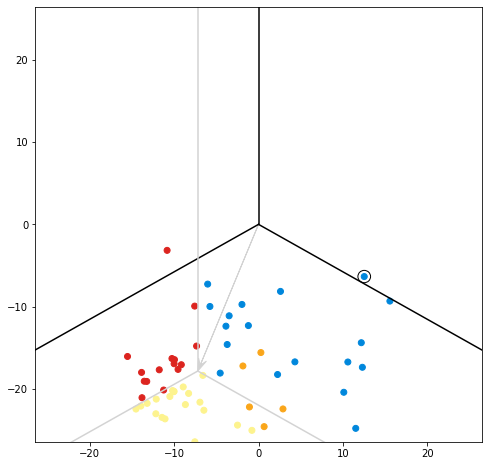

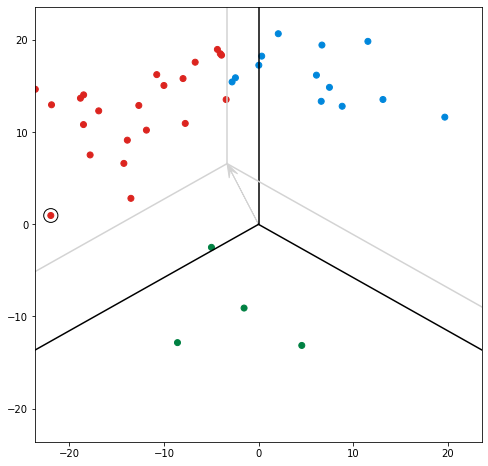

In [32]:
battleground_parties = ['LIB', 'Brexit', 'Green']
for p in battleground_parties:
    battleground(forecast_data, ['LAB', 'CON', p], colour_by='Winner_forecast',
            shift=polling, highlight=list(player_seats.keys()))
battleground(forecast_data[forecast_data.Region=='Scotland'].copy(), ['LAB', 'CON', 'SNP'], colour_by='Winner_forecast',
            shift=scottish_polling, highlight=list(player_seats.keys()))
battleground(forecast_data[forecast_data.Region=='Wales'].copy(), ['LAB', 'CON', 'Plaid'], colour_by='Winner_forecast',
            shift=welsh_polling, highlight=list(player_seats.keys()))

#### Regional battlegrounds

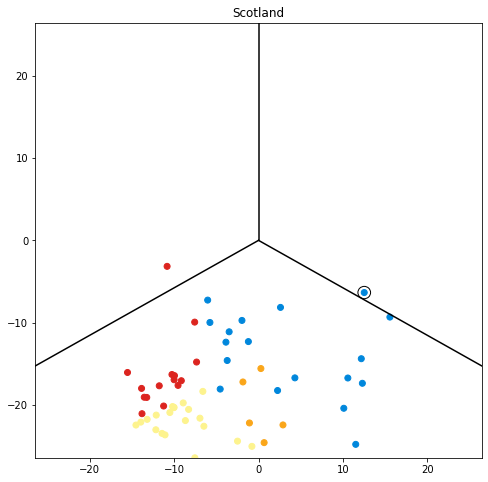

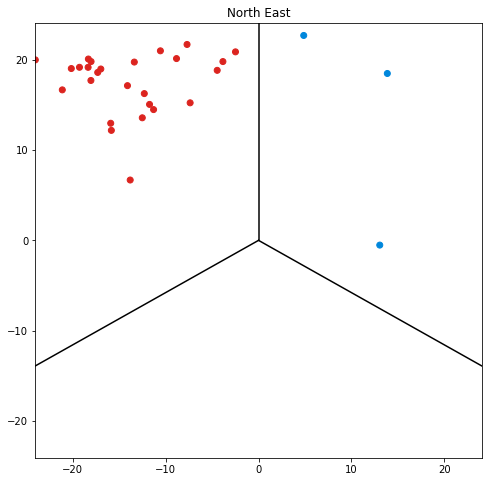

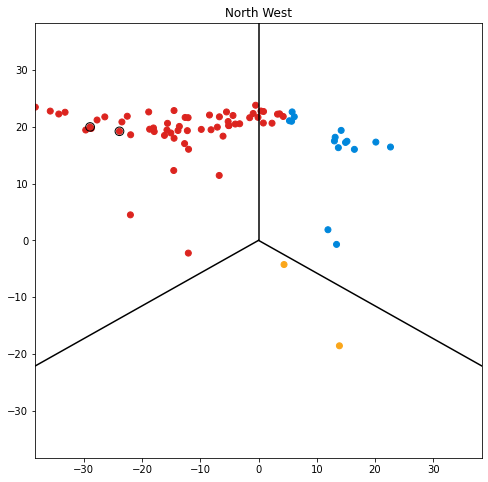

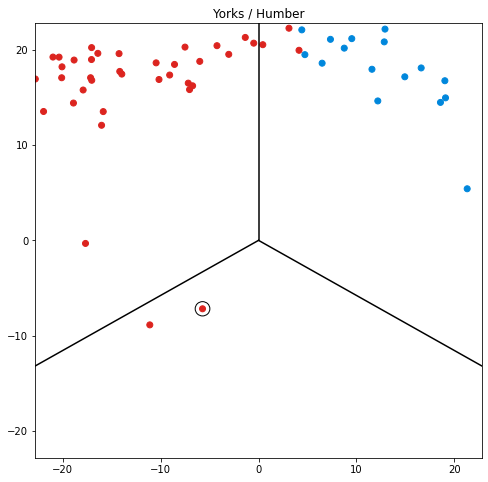

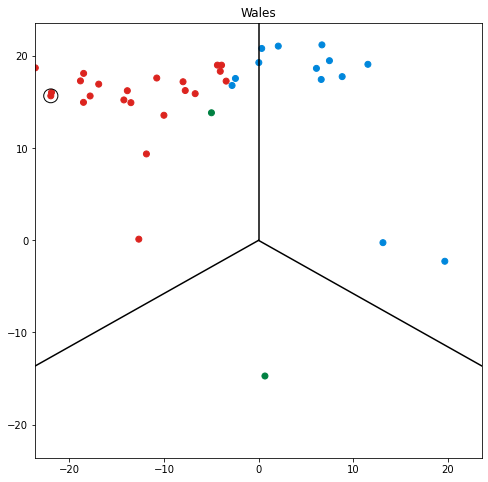

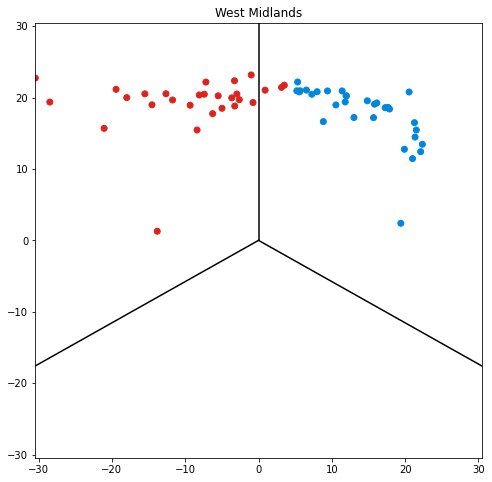

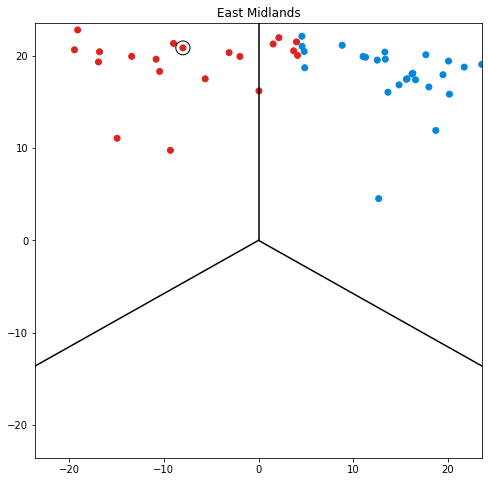

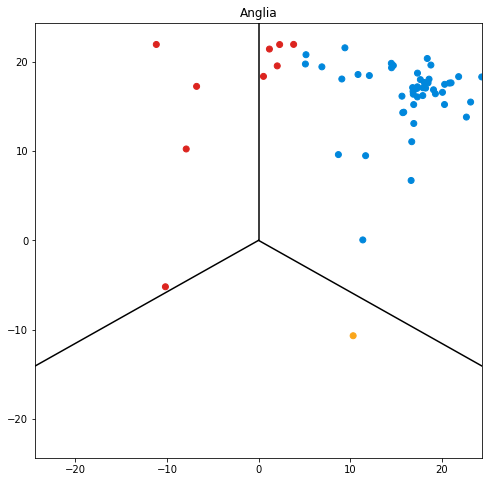

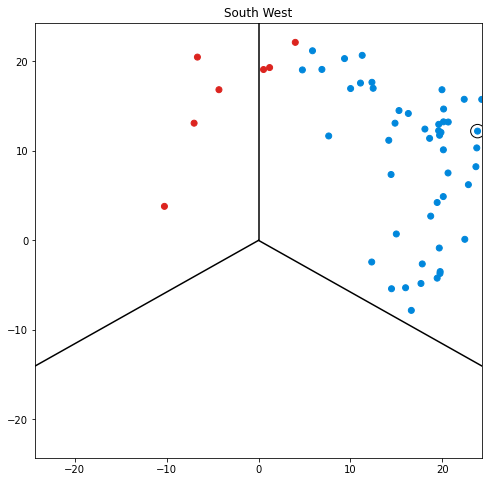

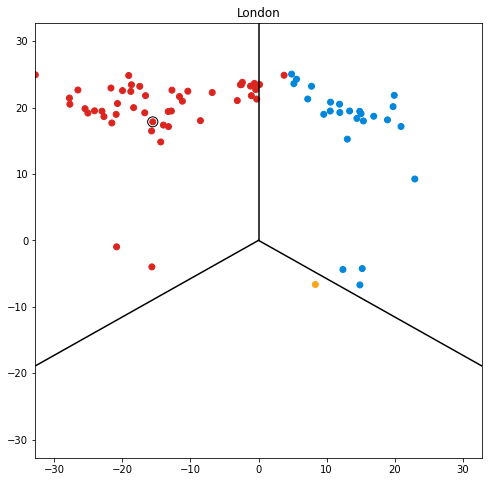

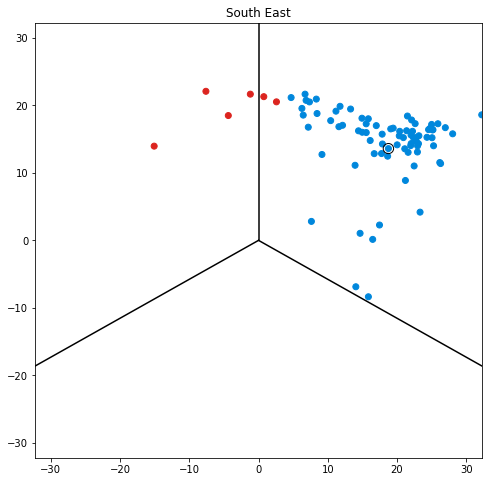

In [33]:
for region in list(data.drop_duplicates(['Area','Region']).sort_values('Area')['Region']):
    if region == 'Northern Ireland':
        continue
    if region == 'Scotland':
        third = 'SNP'
    else:
        third = 'LIB'
    battleground(forecast_data[forecast_data.Region==region].copy(), ['LAB', 'CON', third], 
                 colour_by='Winner_forecast', highlight=list(player_seats.keys()), title=region)

#### Map of each region

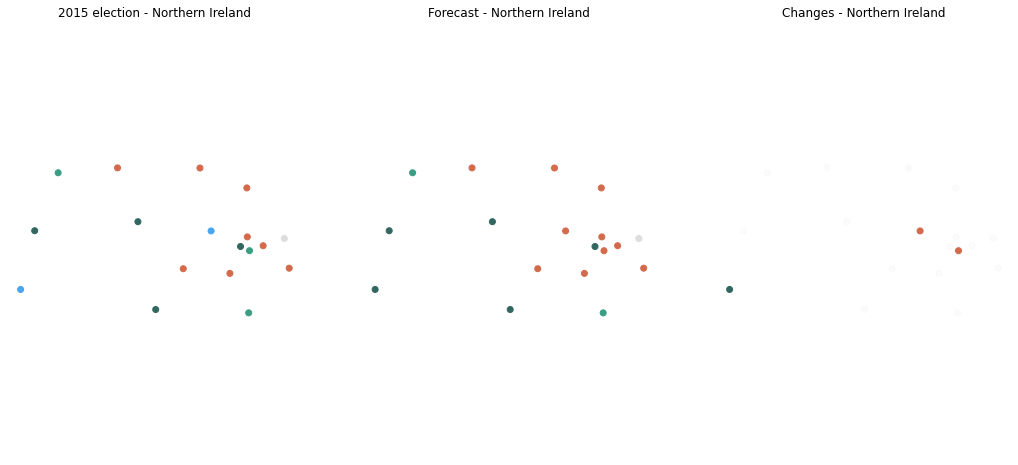

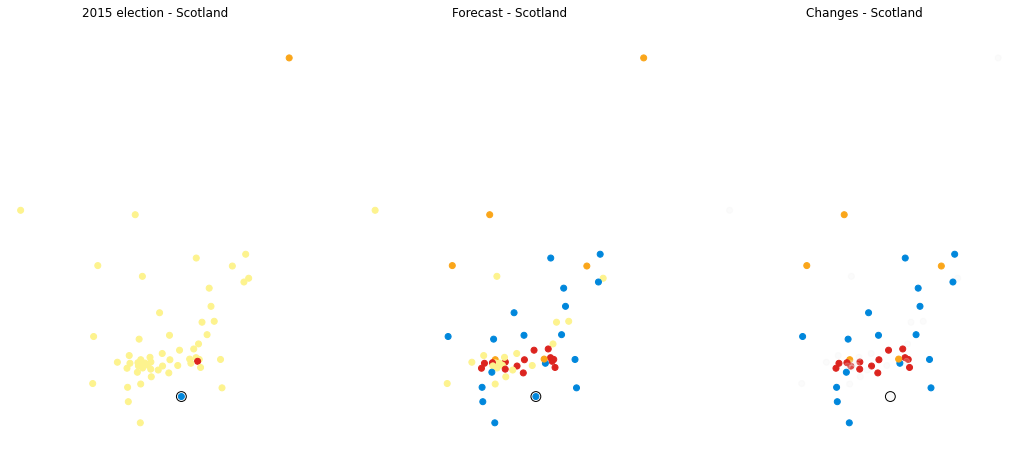

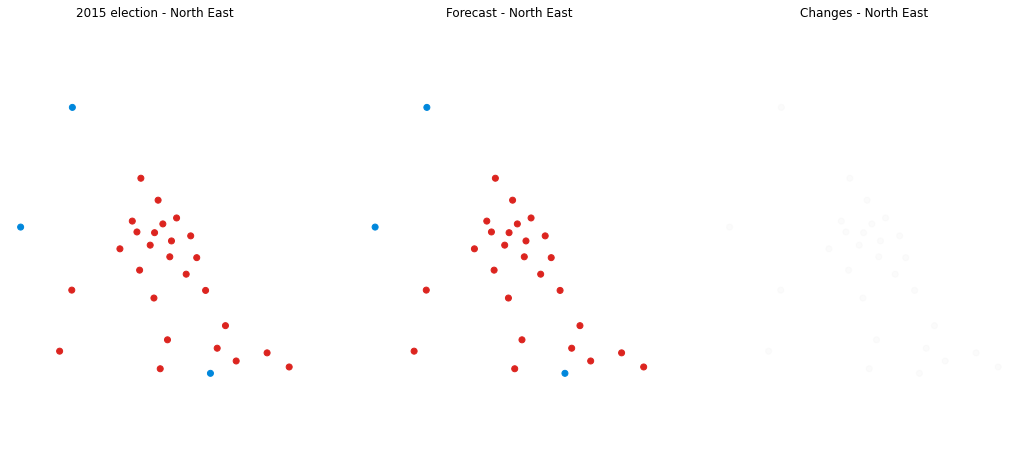

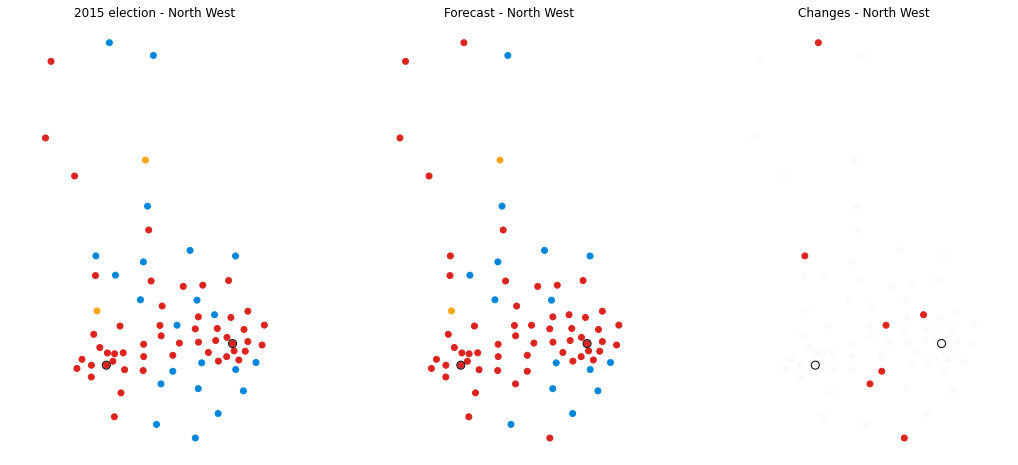

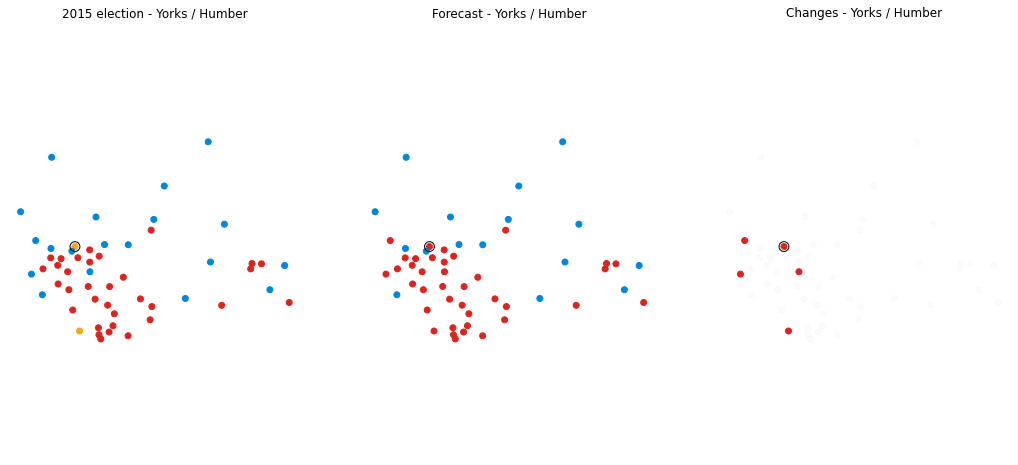

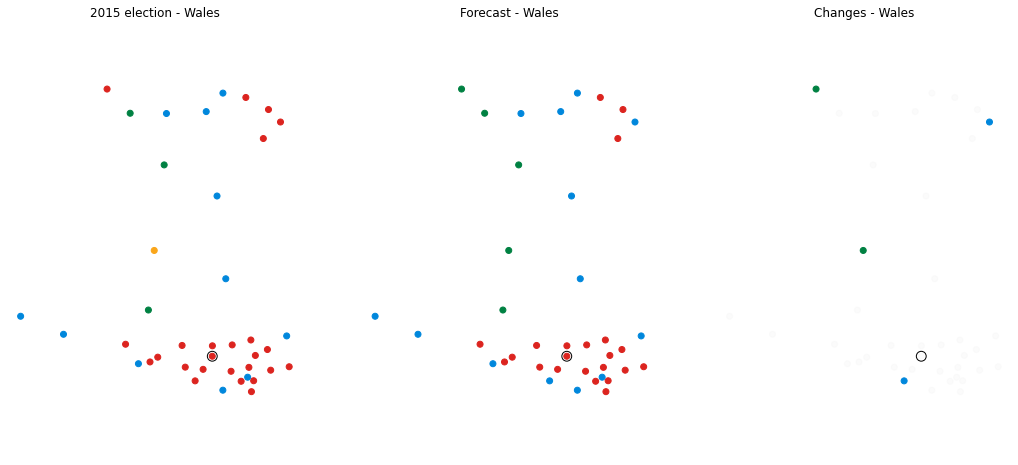

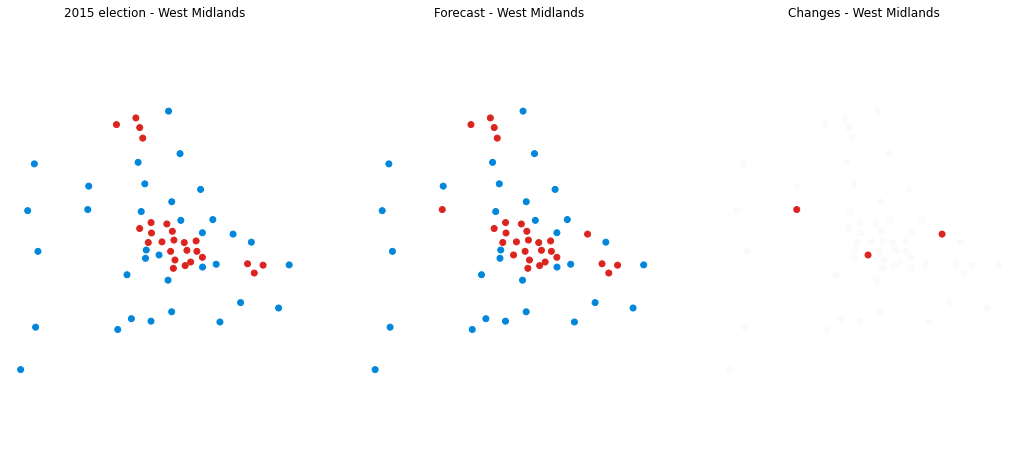

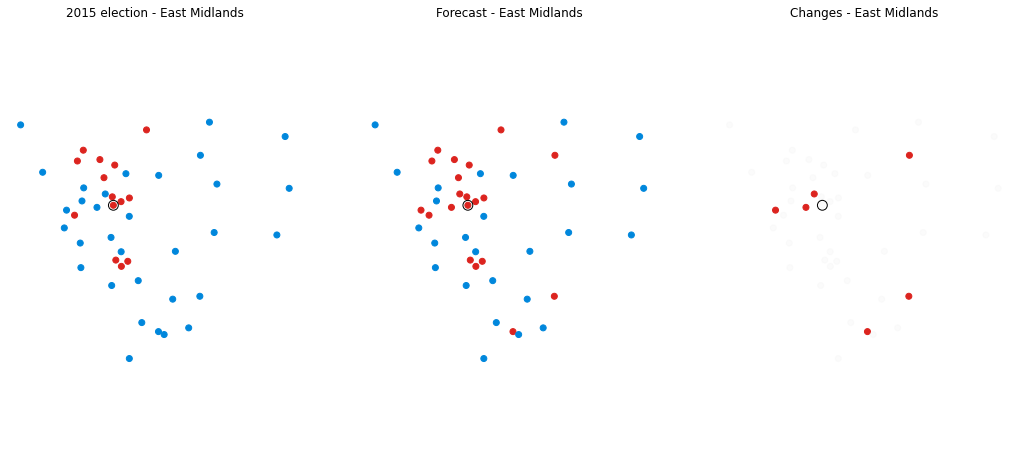

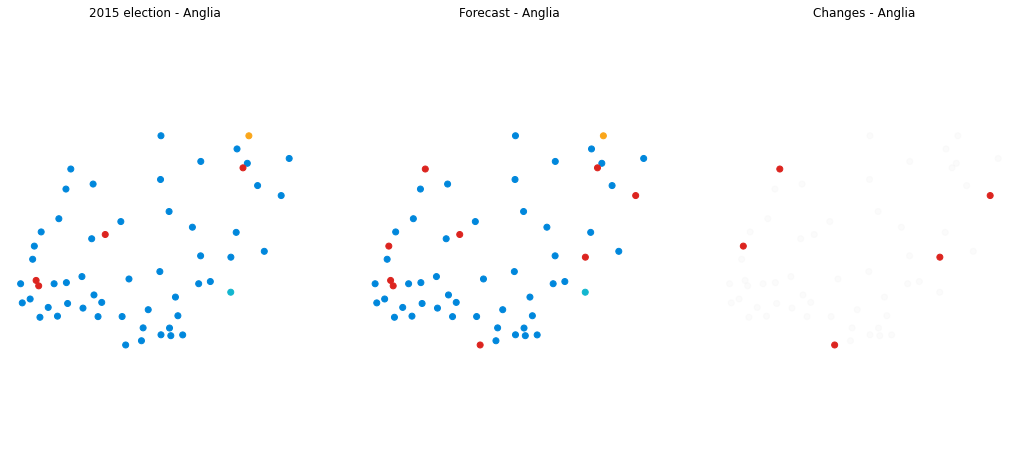

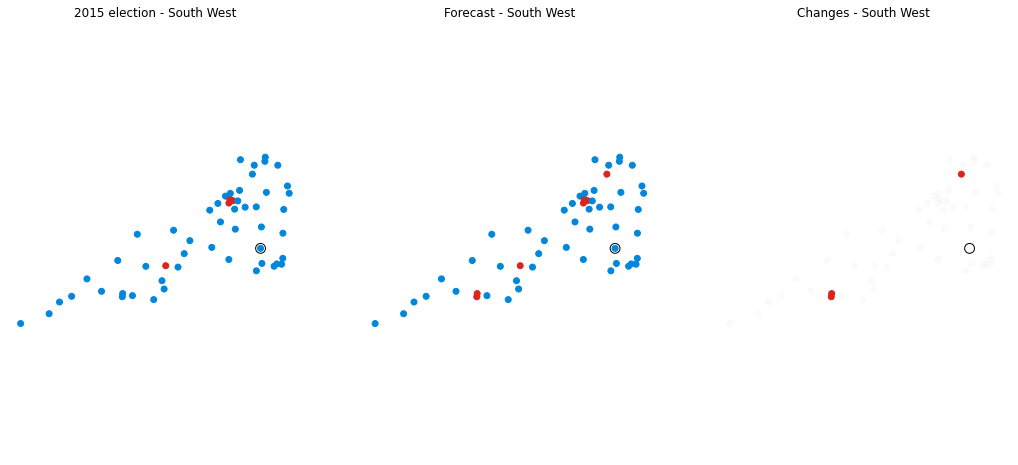

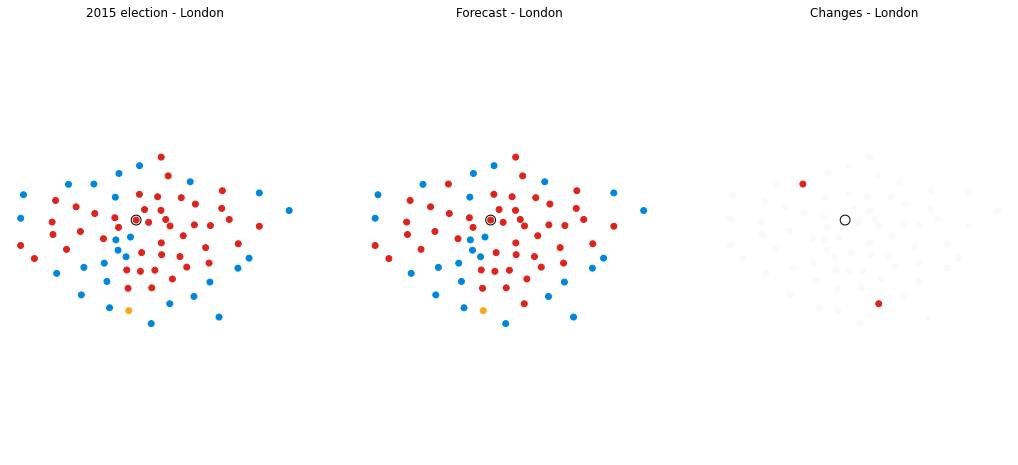

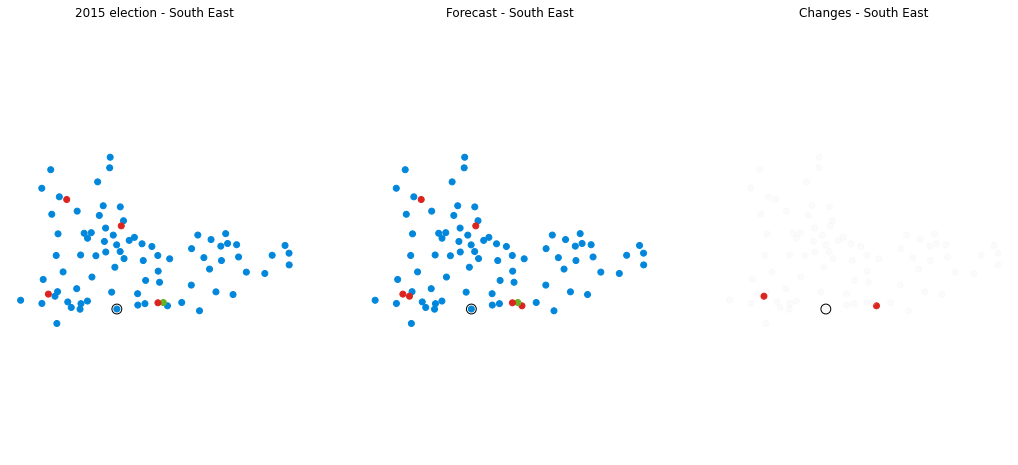

In [34]:
for region in list(data.drop_duplicates(['Area','Region']).sort_values('Area')['Region']):  
    constituency_map(forecast_data[forecast_data['Region'].str.contains(region)], 
                 centroids, by=['Winner', 'Winner_forecast', 'Seat_Change'], highlight=list(player_seats.keys()),
                 title=['2015 election - '+region,'Forecast - '+region, 'Changes - '+region])